# Vehicle Detection and Tracking

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
# NOTE: the next import is only valid 
# for scikit-learn version <= 0.17
# if you are using scikit-learn >= 0.18 then use this:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
#from sklearn.cross_validation import train_test_split
import pickle
from sklearn.externals import joblib
import random
from skimage.feature import hog
from scipy.ndimage.measurements import label


##### load data into 2 arrays : X_cars and X_not_cars

In [36]:
X_cars = np.array(glob.glob('./data/vehicles/*/*.png'))
X_not_cars = np.array(glob.glob('./data/non-vehicles/*/*.png'))
print(len(X_cars))
print(len(X_not_cars))

8792
8968


###### split 'car' data manualy to 20% test, use only data in KITTI_extracted because they are not time serialized
###### also create labels

In [37]:
X_cars_test = X_cars[len(X_cars)-1758:]
y_cars_test = np.ones_like(X_cars_test, dtype=np.float64)
X_cars_train = X_cars[:len(X_cars)-1758]
y_cars_train = np.ones_like(X_cars_train, dtype=np.float64)
#make sure all test data from 'KITTI_extracted' folder
np.savetxt('test.txt', X_cars_test, delimiter='/n', fmt='%s')

print(" ","train","test")
print("X",len(X_cars_train),len(X_cars_test))
print("y",len(y_cars_train), len(y_cars_test))

  train test
X 7034 1758
y 7034 1758


In [38]:
rand_state = np.random.randint(0, 100)
#shuffle using 'train data' only , we are not spliting anything here (test_size=0)
X_cars_train_rndm, X_cars_test_dump, y_cars_train_rndm, y_cars_test_dump = train_test_split(
    X_cars_train, y_cars_train, test_size=0, random_state=rand_state)
#make sure test data is 0, while train data is the same
assert len(X_cars_test_dump)==0 & len(y_cars_test_dump) == 0
assert len(X_cars_train_rndm)==7034 & len(y_cars_train_rndm) == 7034

#shuffle using 'test data' only , we are not spliting anything here (train_size=0)
X_cars_train_dump, X_cars_test_rndm, y_cars_train_dump, y_cars_test_rndm = train_test_split(
    X_cars_test, y_cars_test, train_size=0, random_state=rand_state)
#make sure train data is 0, while test data is the same
assert len(X_cars_test_rndm)==1758 & len(y_cars_test_rndm) == 1758
assert len(X_cars_train_dump)==0 & len(y_cars_train_dump) == 0

print(" ","train","test")
print("X",len(X_cars_train_rndm),len(X_cars_test_rndm))
print("y",len(y_cars_train_rndm), len(y_cars_test_rndm))

  train test
X 7034 1758
y 7034 1758


##### let's split 'not car data' to 20% test as well, 

In [39]:
y = np.zeros_like(X_not_cars, dtype=np.float64)
print(y)
X_not_cars_train, X_not_cars_test, y_not_cars_train, y_not_cars_test = train_test_split(
    X_not_cars, y, train_size=0.8, random_state=rand_state)
print(" ","train","test")
print("X",len(X_not_cars_train),len(X_not_cars_test))
print("y",len(y_not_cars_train), len(y_not_cars_test))

[ 0.  0.  0. ...,  0.  0.  0.]
  train test
X 7174 1794
y 7174 1794


##### data is considerably balanced, lets merge 'car train data' with 'not car train data', and same for car & not car test data

In [40]:
X_train_data = np.hstack((X_cars_train_rndm, X_not_cars_train))
X_test_data = np.hstack((X_cars_test_rndm, X_not_cars_test))
 
y_train_data = np.hstack((y_cars_train_rndm, y_not_cars_train))
y_test_data = np.hstack((y_cars_test_rndm, y_not_cars_test))

print(" ","train","test")
print("X",len(X_train_data),len(X_test_data))
print("y",len(y_train_data), len(y_test_data))

  train test
X 14208 3552
y 14208 3552


In [89]:
#revise data by hand

c = list(zip(X_train_data, y_train_data))
random.shuffle(c)
X_train_, y_train_ = zip(*c)

c_ = list(zip(X_test_data, y_test_data))
random.shuffle(c_)
X_test_, y_test_ = zip(*c_)

import csv

with open('train.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerows(zip(X_train_, y_train_))
with open('test.csv', 'w') as f2:
    writer = csv.writer(f2)
    writer.writerows(zip(X_test_, y_test_))

### Color Classifing
###### now we will try extracting features from images using spatially binned color and color histograms. 

In [2]:
################################ RUN THIS ######################################
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

#### teting classifying by color 

In [6]:

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_color_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features



In [39]:
t=time.time()
# performs under different binning scenarios
spatial = 32
histbin = 512
hist_range = (0, 265)

train_color_features = extract_color_features(X_train_data, cspace='HSV', spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=hist_range)
test_color_features = extract_color_features(X_test_data, cspace='HSV', spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=hist_range)
print(round(time.time()-t, 5), 'Seconds')


37.8392 Seconds


In [40]:
t=time.time()
train_color_features = np.asarray(train_color_features,np.float64)
test_color_features = np.asarray(test_color_features,np.float64)
# Create an array stack of feature vectors

# Fit a per-column scaler
train_color_scaler = StandardScaler().fit(train_color_features)
# Apply the scaler to X
X_trarin_color_scaled = train_color_scaler.transform(train_color_features)

# Fit a per-column scaler
test_color_scaler = StandardScaler().fit(test_color_features)
# Apply the scaler to X
X_test_color_scaled = test_scaler.transform(test_color_features)

print("X",len(X_trarin_color_scaled),len(X_test_color_scaled))
print("sample",X_trarin_color_scaled[0])
print("y",len(y_train_data), len(y_test_data))
print(round(time.time()-t, 5), 'Seconds')

X 14208 3552
sample [ 0.38388063 -1.05298139  1.19274209 ...,  0.          0.          0.        ]
y 14208 3552
2.59272 Seconds


In [46]:
t=time.time()

parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svr = SVC()
clf = GridSearchCV(svr, parameters)
clf.fit(X_trarin_color_scaled, y_train_data)
print("best_params_",clf.best_params_)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of clf = ', round(clf.score(X_test_color_scaled, y_test_data), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', clf.predict(X_test_color_scaled[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test_data[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

best_params_ {'kernel': 'rbf', 'C': 10}
2546.61 Seconds to train SVC...
Test Accuracy of clf =  0.9966
My SVC predicts:  ['1' '1' '1' '1' '1' '1' '1' '1' '1' '1']
For these 10 labels:  ['1' '1' '1' '1' '1' '1' '1' '1' '1' '1']
0.10938 Seconds to predict 10 labels with SVC


##### todo: show some histogram

### HOG Classifing

In [3]:
################################ RUN THIS ######################################
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_HOG_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

In [48]:
t=time.time()

colorspace = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

t=time.time()
train_HOG_features = extract_HOG_features(X_train_data, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
test_HOG_features = extract_HOG_features(X_test_data, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
print(round(time.time()-t, 5), 'Seconds')


206.66514 Seconds


In [49]:
t=time.time()
train_HOG_features = np.asarray(train_HOG_features,np.float64)
test_HOG_features = np.asarray(test_HOG_features,np.float64)
# Create an array stack of feature vectors

# Fit a per-column scaler
train_HOG_scaler = StandardScaler().fit(train_HOG_features)
# Apply the scaler to X
X_trarin_HOG_scaled = train_HOG_scaler.transform(train_HOG_features)

# Fit a per-column scaler
test_HOG_scaler = StandardScaler().fit(test_HOG_features)
# Apply the scaler to X
X_test_HOG_scaled = test_HOG_scaler.transform(test_HOG_features)

print("sample",X_trarin_HOG_scaled[0])
print("X",len(X_trarin_HOG_scaled),len(X_test_HOG_scaled))
print("y",len(y_train_data), len(y_test_data))
print(round(time.time()-t, 5), 'Seconds')

sample [-0.94319214 -0.62877885 -0.53811473 ..., -0.68921752 -0.64553404
 -0.50222601]
X 14208 3552
y 14208 3552
2.82827 Seconds


In [50]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_trarin_HOG_scaled, y_train_data)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test_HOG_scaled, y_test_data), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test_HOG_scaled[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test_data[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

21.89 Seconds to train SVC...
Test Accuracy of SVC =  0.9834
My SVC predicts:  ['1' '1' '1' '1' '1' '1' '1' '1' '1' '1']
For these 10 labels:  ['1' '1' '1' '1' '1' '1' '1' '1' '1' '1']
0.0 Seconds to predict 10 labels with SVC


In [51]:
t=time.time()

parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svrHOG = SVC()
clfHOG = GridSearchCV(svrHOG, parameters)
clfHOG.fit(X_trarin_HOG_scaled, y_train_data)
print("best_params_",clfHOG.best_params_)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of clf = ', round(clfHOG.score(X_test_HOG_scaled, y_test_data), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', clfHOG.predict(X_test_HOG_scaled[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test_data[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

best_params_ {'kernel': 'rbf', 'C': 10}
4015.95 Seconds to train SVC...
Test Accuracy of clf =  0.9958
My SVC predicts:  ['1' '1' '1' '1' '1' '1' '1' '1' '1' '1']
For these 10 labels:  ['1' '1' '1' '1' '1' '1' '1' '1' '1' '1']
0.24116 Seconds to predict 10 labels with SVC


### now let's combine all of this together

In [4]:
################################ RUN THIS ######################################
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)

        concatenated_file_features = single_img_features(image, color_space, spatial_size,
                        hist_bins, orient, pix_per_cell, cell_per_block, hog_channel,
                        spatial_feat, hist_feat, hog_feat)
        features.append(concatenated_file_features)
    # Return list of feature vectors
    return features

In [41]:
t=time.time()

spatial = (16,16)#(32,32)
histbins = 32#512
hist_range = (0, 255)
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
#switchs !
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


train_features = extract_features(X_train_data, color_space=colorspace, 
                        spatial_size=spatial, hist_bins=histbins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
test_features = extract_features(X_test_data, color_space=colorspace, 
                        spatial_size=spatial, hist_bins=histbins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print(round(time.time()-t, 5), 'Seconds')


438.13468 Seconds


### save data:
now that we are satisfied with our data extraction, we save data to make it easy to use it on next stages

In [42]:
t=time.time()

pickle.dump( train_features, open( "data/train_YCrCb_16_32.p", "wb" ) )
pickle.dump( test_features, open( "data/test_YCrCb_16_32.p", "wb" ) )
#how to load : 
#train_features = pickle.load( open( "data/train.p", "rb" ) )
#test_features = pickle.load( open( "data/test.p", "rb" ) )

print(round(time.time()-t, 2), 'Seconds')

11.99 Seconds


In [43]:
################################ RUN THIS ######################################
t=time.time()
def data_scaler(train_features, test_features):
    train_features = np.asarray(train_features,np.float64)
    test_features = np.asarray(test_features,np.float64)
    # Create an array stack of feature vectors

    # Fit a per-column scaler
    train_scaler = StandardScaler().fit(train_features)
    # Apply the scaler to X
    X_trarin_scaled = train_scaler.transform(train_features)

    # Fit a per-column scaler
    test_scaler = StandardScaler().fit(test_features)
    # Apply the scaler to X
    X_test_scaled = test_scaler.transform(test_features)
    return train_scaler, X_trarin_scaled, test_scaler, X_test_scaled

#print("X",len(X_trarin_scaled),len(X_test_scaled))
#print("sample",X_trarin_scaled[0])
#print("y",len(y_train_data), len(y_test_data))
print(round(time.time()-t, 2), 'Seconds')

0.0 Seconds


In [44]:
#todo: use function above
train_scaler, X_trarin_scaled, test_scaler, X_test_scaled = data_scaler(train_features, test_features)

In [45]:
t=time.time()

clf = SVC(C=10.0, kernel='rbf')
clf.fit(X_trarin_scaled, y_train_data)

#if you don't know the best params
#parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
#svr = SVC()
#clf = GridSearchCV(svr, parameters)
#print("best_params_",clf.best_params_)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of clf = ', round(clf.score(X_test_scaled, y_test_data), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', clf.predict(X_test_scaled[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test_data[0:n_predict])

print(round(time.time()-t, 2), 'Seconds to predict', n_predict,'labels with SVC')

336.94 Seconds to train SVC...
Test Accuracy of clf =  0.9983
My SVC predicts:  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
For these 10 labels:  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
0.25 Seconds to predict 10 labels with SVC


### save model

In [46]:

joblib.dump(clf, 'clf_svc_YCrCb_16_32.pkl')
#how to load :
# _clf = joblib.load('clf_svc.pkl') 

['clf_svc_YCrCb_16_32.pkl']

#### search for cars

In [5]:
################################ RUN THIS ######################################
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0.]
prediction [ 0

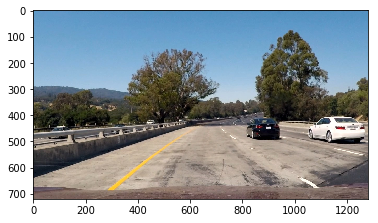

11.72 Seconds to finding cars


In [187]:
t=time.time()
image = mpimg.imread('data/object-detection-crowdai/1479498381465380454.jpg')
image = mpimg.imread('test_images/test1.jpg')
draw_image = np.copy(image)
#print("image",image)
#imagepng = mpimg.imread("data/non-vehicles/Extras/extra1.png")
#print("imagepng",imagepng)
# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255

y_start_stop = [None, None] # Min and max in y to search in slide_window()

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, clf, train_scaler, color_space=colorspace, 
                        spatial_size=spatial, hist_bins=histbins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       
print(len(hot_windows),"hot window")
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)
plt.show()
print(round(time.time()-t, 2), 'Seconds to finding cars')

### use better car finder

In [48]:
################################ RUN THIS ######################################
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,window_size=64):
    
    all_windows = []
    hot_windows = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    #ctrans_tosearch = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = ()
    #window_size = 64
    nblocks_per_window = (window_size // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = 2#(nyblocks - nblocks_per_window) // cells_per_step
    #print(nysteps, '=(',nyblocks,'-',nblocks_per_window,')//', cells_per_step,'=', nysteps)
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            scale = scale
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window_size, xleft:xleft+window_size], (64,64))
            # Extract HOG for this patch
            ch1 = subimg[:,:,0]
            ch2 = subimg[:,:,1]
            ch3 = subimg[:,:,2]
            hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
            hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
            hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
            hog_feat1 = hog1.ravel() 
            hog_feat2 = hog2.ravel() 
            hog_feat3 = hog3.ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            #subimg = cv2.resize(ctrans_tosearch[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
            
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window_size*scale)
            
            # Extract the image patch
            window = ((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart))
            #ex: window ((0, 0), (96, 96))
            
            cv2.rectangle(draw_img,window[0],window[1],(255,255,255),4) 
            all_windows.append(window)
            if test_prediction == 1:
                cv2.rectangle(draw_img,window[0],window[1],(0,0,255),6) 
                hot_windows.append(window)
    return draw_img, hot_windows, all_windows

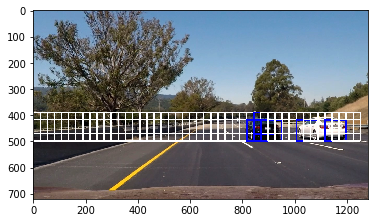

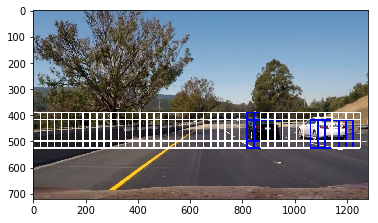

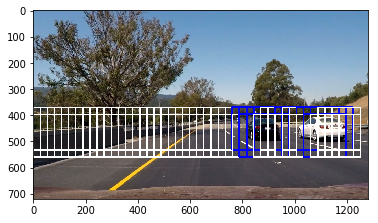

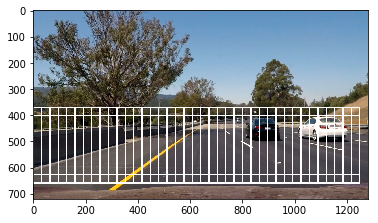

11.16 Seconds to finding cars
24


In [49]:
################################ RUN THIS ######################################
"""
ystart = 390
ystop = 656
scale = 1.5
t = time.time()
#image = mpimg.imread('data/object-detection-crowdai/1479498381465380454.jpg')
image = mpimg.imread('test_images/test6.jpg')
out_img, hot_windows, all_windows = find_cars(image, ystart, ystop, scale, clf, train_scaler, orient, pix_per_cell, cell_per_block, spatial, histbins)
plt.imshow(out_img)
plt.show()
"""


#image = mpimg.imread('data/object-detection-crowdai/1479498381465380454.jpg')
image = mpimg.imread('test_images/test6.jpg')

def find_cars_from_multiscalewindows(image, clf, train_scaler, orient, pix_per_cell, cell_per_block,
                                     spatial, histbins,vis=False):
    ystart = [390,390,370,370]
    ystop = [656,646,646,646]#[656,646,646,646,646]
    scale = [1.7,1.7,1.7,2]#[1.5,1.5,1.5,1.5,1.5]
    windows_sizes = [48,64,96,128]#[64,96,112,128,160]
    t = time.time()
    hot_windows = []
    all_windows = []
    #t = time.time()
    for i in range(len(windows_sizes)):
        send_image = np.copy(image)
        out_img, sub_hot_windows, sub_all_windows = find_cars(send_image, ystart[i], ystop[i], scale[i], clf,
                                                              train_scaler, orient, pix_per_cell, cell_per_block,
                                                              spatial, histbins,windows_sizes[i])
        hot_windows.extend(sub_hot_windows), all_windows.append(sub_all_windows)
        if vis:
            plt.imshow(out_img)
            plt.show()
    #print(round(time.time()-t, 2), 'Seconds to finding cars')
    return hot_windows, all_windows
t = time.time()
hot_windows, all_windows = find_cars_from_multiscalewindows(image, clf, train_scaler, orient, pix_per_cell,
                                                            cell_per_block, spatial, histbins, True)
print(round(time.time()-t, 2), 'Seconds to finding cars')
print(len(hot_windows))


In [15]:
################################ RUN THIS ######################################

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


In [24]:
################################ RUN THIS ######################################

spatial = (16,16)#(32,32)
histbins = 32#512
hist_range = (0, 256)
colorspace = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
#switchs !
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

def prepare_data_and_model(is_16_32=True):
    if(is_16_32):
        train_features = pickle.load( open( "data/train_16_23.p", "rb" ) )
        test_features = pickle.load( open( "data/test_16_23.p", "rb" ) )
        clf = joblib.load('clf_svc_16_32.pkl') 
    else :
        train_features = pickle.load( open( "data/train.p", "rb" ) )
        test_features = pickle.load( open( "data/test.p", "rb" ) )
        clf = joblib.load('clf_svc.pkl') 
    train_scaler, X_trarin_scaled, test_scaler, X_test_scaled = data_scaler(train_features,test_features)
    return clf, train_scaler

def car_detection_pipeline(image, show_rsult_with_heat=False):
    
    hot_windows, all_windows = find_cars_from_multiscalewindows(image, clf, train_scaler, orient,
                                                                pix_per_cell, cell_per_block, spatial, histbins,vis=False)
    #out_img, hot_windows, all_windows = find_cars(image, ystart, ystop, scale, clf, train_scaler,
    #                                              orient, pix_per_cell, cell_per_block, spatial, histbins)

    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    if show_rsult_with_heat:
        fig = plt.figure()
        plt.subplot(121)
        plt.imshow(draw_img)
        plt.title('Car Positions')
        plt.subplot(122)
        plt.imshow(heatmap, cmap='hot')
        plt.title('Heat Map')
        fig.tight_layout()
        plt.show()
    
    return draw_img


In [25]:
################################ RUN THIS ######################################
#init app - one time only
t = time.time()
clf, train_scaler = prepare_data_and_model()#fisrt time only
print(round(time.time()-t, 2), 'Seconds to loading')

8.73 Seconds to loading


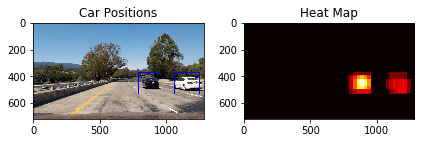

10.33 Seconds to finding car


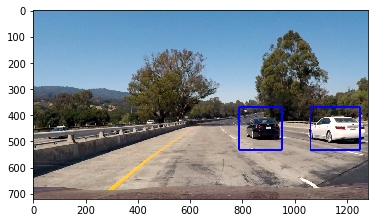

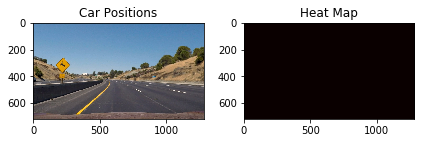

10.42 Seconds to finding car


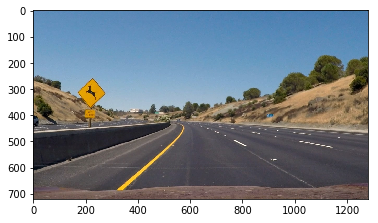

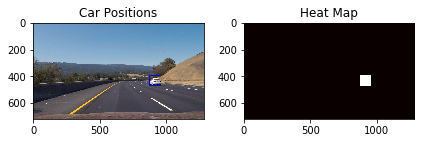

10.16 Seconds to finding car


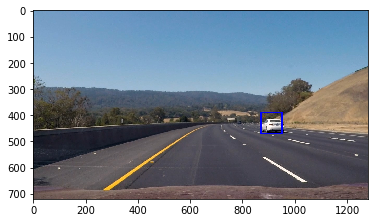

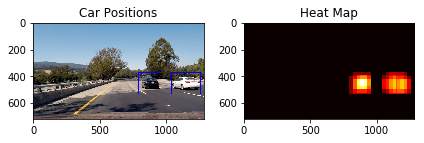

10.23 Seconds to finding car


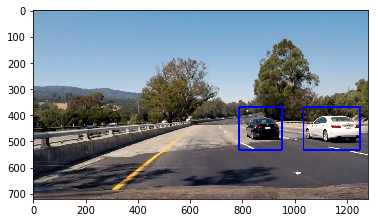

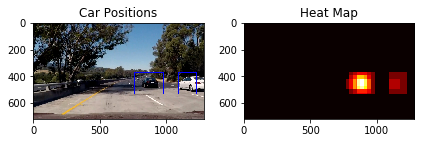

10.17 Seconds to finding car


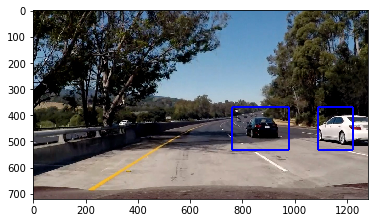

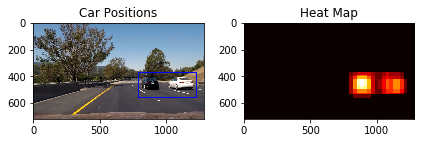

10.08 Seconds to finding car


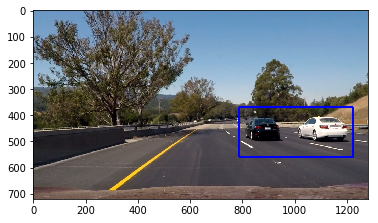

In [50]:
################################ RUN THIS ######################################

t = time.time()
image = mpimg.imread('test_images/test1.jpg')
final_image = car_detection_pipeline(image,True)
print(round(time.time()-t, 2), 'Seconds to finding car')
plt.imshow(final_image)
plt.show()
t = time.time()
image = mpimg.imread('test_images/test2.jpg')
final_image = car_detection_pipeline(image,True)
print(round(time.time()-t, 2), 'Seconds to finding car')
plt.imshow(final_image)
plt.show()
t = time.time()
image = mpimg.imread('test_images/test3.jpg')
final_image = car_detection_pipeline(image,True)
print(round(time.time()-t, 2), 'Seconds to finding car')
plt.imshow(final_image)
plt.show()
t = time.time()
image = mpimg.imread('test_images/test4.jpg')
final_image = car_detection_pipeline(image,True)
print(round(time.time()-t, 2), 'Seconds to finding car')
plt.imshow(final_image)
plt.show()
t = time.time()
image = mpimg.imread('test_images/test5.jpg')
final_image = car_detection_pipeline(image,True)
print(round(time.time()-t, 2), 'Seconds to finding car')
plt.imshow(final_image)
plt.show()
t = time.time()
image = mpimg.imread('test_images/test6.jpg')
final_image = car_detection_pipeline(image,True)
print(round(time.time()-t, 2), 'Seconds to finding car')
plt.imshow(final_image)
plt.show()

In [51]:
#### cell 22
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [52]:
#### cell 23
#clear Line class
#start
white_output = 'test_video_result3.mp4'
clip1 = VideoFileClip("test_video3.mp4")
white_clip = clip1.fl_image(car_detection_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_video_result3.mp4
[MoviePy] Writing video test_video_result3.mp4


100%|████████████████████████████████████████| 115/115 [18:20<00:00,  9.52s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_result3.mp4 

Wall time: 18min 22s


In [53]:
#### cell 23
#clear Line class
#start
white_output = 'project_video_res.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(car_detection_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_res.mp4
[MoviePy] Writing video project_video_res.mp4


100%|███████████████████████████████████▉| 1260/1261 [3:18:52<00:09,  9.49s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_res.mp4 

Wall time: 3h 18min 53s
